# Part 4: Transfer

Deep neural networks learn representations of data that can be helpful for related but different tasks than that for which they were originally trained. This is a valuable property, because it suggests that some of the representation learning can be **transferred** to a different related task.

In this part of the assignment, you will load a pre-trained neural network originally trained for one image recognition task and will apply and fine tune that model for a related but different image recognition task on a different dataset, all using PyTorch. Specifically, we will use a pretrained ResNet model (a convolutional neural network with a residual component) to classify 32 by 32 pixel color images of animals, automobiles, planes, and ships (10 classes in total).

**Learning objectives.** You will:
1. Apply a pre-trained ResNet model for a related but different image recognition task by retraining the final decision layer.
2. Fine tune a pre-trained model to improve model performance on a new task.
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch.
5. Compute and visualize gradient class activation maps as model saliancy visualizations
6. Consider the role of interpretability and explainability in machine learning models

While it is possible to complete this part using CPU compute, it may be very slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

In [1]:
# Run but DO NOT MODIFY this code

# Import libraries
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())

# Prepare DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


The following code then visualizes some random examples of the training data.

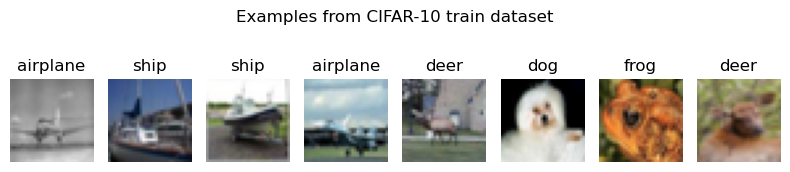

In [2]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
"horse", "ship", "truck"]

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True))
images, labels = next(dataiter)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 8, figsize=(8, 2))
fig.suptitle('Examples from CIFAR-10 train dataset', fontsize=12)

# Plot 8 images
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title(f"{classes[labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Task 1

The following code imports a pretrained ResNet model that was trained to classify color images on the ImageNet dataset. The images in that dataset represent 1,000 possible classes. By contrast, the images in our dataset are classified into one of just 10 classes.

Unsurprisingly, you will find that you cannot directly apply the ResNet model to prediction on our CIFAR-10 dataset. However, we can achieve surprising performance by **only changing the output layer** of the model, leaving all parameters prior to the final layer unchanged (setting `requires_grad = False` for an element of `model.parameters()` should accomplish this freezing). Freeze the model parameters and replacing the final `.fc` layer with a fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with just 10 output units.

In [3]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)

# Write code to finish task 1 here

# Freeze every parameter in model
for param in model.parameters():
    param.requires_grad = False
# Unfreeze params for final .fc layer
for param in model.fc.parameters():
    param.requires_grad = True

# print(model.fc.in_features) # Used for creating new replacement layer - in_features = 512

model.fc = nn.Linear(512, 10, bias=False)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Task 2

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to optimize the parameters of **the output layer only** (which should be what happens if you completed task 1 correctly) on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). You may use Tensorboard but are not required to do so.

You should be able to achieve a validation accuracy of 40% or better without changing any model parameters except the last layer, though you may need to experiment with the training hyperparameters to accomplish this. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [ ]:
# Write code for task 2 here

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
# Set hyperparameters for training
epochs = 15
lr = 0.02


def evaluate(val_dl):
    # Evaluating model on validation set
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # Disable gradient tracking
        for val_inputs, val_labels in val_dl:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            # Forward propagation
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs, dim=1)  # Get predicted class

            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = val_correct / val_total
    return val_acc


# Fitting model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0

    for batch, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward propagation
        outputs = model(inputs)

        # Loss computation
        loss = loss_fn(outputs, labels)
        # Backward propagation
        loss.backward()

        # Gradient step
        optimizer.step()
        optimizer.zero_grad()

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    val_acc = evaluate(val_loader)
    train_acc = correct / total
    print(f"Epoch {epoch+1} of {epochs}, Validation Accuracy = {val_acc:.4f}")

test_acc = evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")



Epoch 1 of 15, Validation Accuracy = 0.4256
Epoch 2 of 15, Validation Accuracy = 0.4312


*Briefly explain for task 2 here*

I chose to train the model over 15 epochs with a learning rate of 0.02, which allowed me to get the validation accuracy (0.4522) and test accuracy (0.4578) above the threshold of 0.4.

## Task 3

We can achieve a higher level of performance by **fine-tuning** the entire pre-trained model on the new task. Start with the original pretrained ResNet model and replace the output layer as before, but this time **do not** freeze any of the other parameters.

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fine tune the parameters (that is, normal training, but usually with a relatively small learning rate) on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). You may use Tensorboard but are not required to do so.

You should be able to achieve a validation accuracy of 75% or better, though you may need to experiment with the training hyperparameters to accomplish this. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [ ]:
# Write code to finish task 3 here

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10, bias=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
# Set hyperparameters for training
epochs = 15
lr = 0.005

# Fitting model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0

    for batch, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward propagation
        outputs = model(inputs)

        # Loss computation
        loss = loss_fn(outputs, labels)
        # Backward propagation
        loss.backward()

        # Gradient step
        optimizer.step()
        optimizer.zero_grad()

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    val_acc = evaluate(val_loader)
    train_acc = correct / total
    print(f"Epoch {epoch+1} of {epochs}, Validation Accuracy = {val_acc:.4f}")

test_acc = evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")



Epoch 1 of 15, Validation Accuracy = 0.6876
Epoch 2 of 15, Validation Accuracy = 0.7293
Epoch 3 of 15, Validation Accuracy = 0.7534
Epoch 4 of 15, Validation Accuracy = 0.7582
Epoch 5 of 15, Validation Accuracy = 0.7688
Epoch 6 of 15, Validation Accuracy = 0.7780
Epoch 7 of 15, Validation Accuracy = 0.7708
Epoch 8 of 15, Validation Accuracy = 0.7798
Epoch 9 of 15, Validation Accuracy = 0.7747
Epoch 10 of 15, Validation Accuracy = 0.7719
Epoch 11 of 15, Validation Accuracy = 0.7789
Epoch 12 of 15, Validation Accuracy = 0.7783
Epoch 13 of 15, Validation Accuracy = 0.7821
Epoch 14 of 15, Validation Accuracy = 0.7810
Epoch 15 of 15, Validation Accuracy = 0.7811
Test Accuracy: 0.7841


*Briefly explain for task 3 here*

I chose a learning rate of 0.005 and 15 epochs. This allowed me to get both the final validation accuracy (0.7830) and the test accuracy (0.7854) above the threshold of 0.75. It is worth noting that the learning rate that I chose for fine-tuning was significantly less than that of the previous model (0.02).

## Task 4

Though they can achieve impressive performance, it can be very challenging to make sense of how deep learning models make predictions. One common approach to analyzing deep convolutional neural networks for image recognition tasks is to compute a saliancy map, a heat map over an image input that highlights the regions most contributing activation scores to the decision layer of the model. 

For example, the [The Bishop Deep Learning Book](https://www.bishopbook.com/), Section 10.3.3, describes the Gradient Class Activation Map (Grad-CAM) method introduced by [Selvaraju and all 2016](https://arxiv.org/abs/1610.02391). Given an image and label, this technique computes the derivatives of the score for the label's output unit with respect to the weights of (usually) the last convolutional layer. These are used to compute a weighted average of the feature maps of the final convolutional layer, which is then upsampled and projected as a heatmap onto the original image. Conceptual at a high level, the idea is that this estimates the regions of the image that provide significant contributions to the activation for the given output unit.


Below, we install and import the `pytorch-grad-cam` package, which you can [see on Github here](https://github.com/jacobgil/pytorch-grad-cam/tree/master). Compute and visualize the Grad-CAM for the **original** pretrained (**not** fine-tuned) ResNet model for each of the three images in `cat_images` (`tuxedo_cat.jpg`, `kittens.jpg`, and `dog_cat.jpg`), each with respect to the `cat` label. 

We recommend reviewing the [introductory documentation here](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html) to familiarize yourself with the usage of `GradCAM`, especially [this minimal example](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html#using-from-code-as-a-library) which also uses a ResNet model (a slightly larger one than used here). Note also the use of `ClassifierOutputTarget(281)`; 281 is the index corresponding to `cat` in the imagenet dataset on which ResNet was trained, and that's what you'll be looking for in these example images as well, so you can use it in the same way.

You will probably need to install the grad-cam package. To do so, uncommonent and run the following cell.

Now you should be able to import from the `pytorch_grad_cam` package.

In [ ]:
pip install grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Write code for task 4 here
from PIL import Image
import torchvision.transforms as transforms
import cv2  # Import OpenCV for resizing the heatmap


model = models.resnet18(pretrained=True)
model.eval()
# Define target layer for GradCAM
target_layers = [model.layer4[-1]]

# Need to preprocess image so it is a tensor
def preprocess_image(image_path):
    # open image
    img = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor, img

# List image paths
image_paths = ["cat_images/tuxedo_cat.jpg", "cat_images/kittens.jpg", "cat_images/dog_cat.jpg"]

# Create GradCAM object
cam = GradCAM(model=model, target_layers=target_layers)

for image_path in image_paths:
    # Preprocess image
    input_tensor, original_img = preprocess_image(image_path)
    
    input_tensor = input_tensor.to(device)

    # Define the target class (Cat in ImageNet corresponds to index 281)
    targets = [ClassifierOutputTarget(281)]

    # Compute GradCAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # 1 image per batch, just get first
    grayscale_cam = grayscale_cam[0, :]

    # Need to resize due to dimension mismatch
    grayscale_cam_resized = cv2.resize(grayscale_cam, (original_img.size[0], original_img.size[1]))

    # Visualize GradCAM on original image
    visualization = show_cam_on_image(np.array(original_img) / 255.0, grayscale_cam_resized, use_rgb=True)

    # Display visualization
    Image.fromarray(visualization).show()

    # Image.fromarray(visualization).save(f"grad_cam_{image_path.split('.')[0]}.jpg")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


![alt text](./dog_cat.png)

![alt text](./kittens.png)

![alt text](./tuxedo.png)

*Optional Extra challenge* If you would like an extra challenge for your PyTorch programming, you could try implementing Grad-CAM yourself instead of using the library. The main challenge is that some of the derivatives you need for computing the feature map weights are not stored by default because they are not leaf nodes in the PyTorch computational graph. Common approaches to address this involve modifying the `forward` method, potentially registering a [Pytorch `hook`](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html). Don't try this until you have finished the rest of the assignment, and not that it is not for points.

## Task 5

Not everyone agrees that saliency maps like those you computed above are necessarily helpful for understanding machine learning models. Read at least Sections 1-2 (about 5 pages) of [Dr. Rudin](https://users.cs.duke.edu/~cynthia/)'s [2019 Nature perspective article](https://arxiv.org/abs/1811.10154). Then write 1-2 paragraphs in response to each of the following two questions.

1. Summarize the difference between **interpretable** and **explainable** machine learning models as described in the article.
2. Do you think that saliency maps such as from Grad-CAM are helpful for explaining image recognition models? Briefly explain why or why not.

*Write your responses for task 5 here*

1. Rudin describes interpretable ML models as those which "provide their own explanations" as to the process used by the model to compute its results, and remain "faithful to what the model actually computes." She says that one common indicator of interpretable models is sparsity, and I thought it was really interesting how, to back this up, she cited data about how humans can only handle 5-9 cognitive entities at once. On the other hand, explainable models are those in which a second model is created to explain the first "black box" model. A black box model is one whose internal workings and processes cannot be easily understood by humans, such as for tasks involving image recognition. Rudin argues that explainable models can be unreliable and misleading, which is why interpretable models should be more used for high-stakes problems. This is a very interesting claim, since some sources say that black box models often outperform interpretable models, but Rudin argues for the importance of being able to understand the model rather than just trusting it to be correct.

2. I think that saliency maps are helpful for explaining a big-picture structure of image recognition models, but more interpretable models should be used in higher-stakes decision-making situations. As Rudin states in section 2.2 of her article, explanations do not have 100% accuracy, and if they did, then the model itself would be interpretable, and the explanation would be obsolete. This inherently means that black box models cannot be trusted by humans since the explainable model itself cannot fully explain the black box. Still, if an explainable model has 90% agreement with the original model, it could give very useful insights as to how the black box model works. It has been shown that in deep learning, specifically complex image classification tasks, it is difficult to craft an effective interpretable model due to the recursive nature of the model's computational processes. As a result, very good image classification models are frequently black box models. This does not inherently mean that the user cannot trust the model; it also does not mean that the user can trust the explainable model with 100% certainty. Still, the explainable model would help the user understand the black box's processes for the most part, which could prove very helpful and be very beneficial. On the other hand, if the model was meant to predict whether a certain individual committed a crime and should be jailed for life, the black box model, and consequently its explainable model, cannot be fully trusted to make the right decision. In situations where the stakes are higher, interpretable models are necessary even though they could be less accurate, because users can understand them and will be more likely to actually catch when an incorrect decision has been made. To more directly answer the question, saliency maps specifically can be very useful for learners such as myself to understand an image recognition model. However, that map may be misleading at times, or fail to capture the entire decision-making process of the black box model, and thus cannot be fully trusted in a higher-stakes situation.